# Regression Analysis: Solution Exercises

In [58]:
# Settings
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

import numpy as np
import matplotlib.pylab as plt
%matplotlib inline 
#plt.style.use('seaborn-whitegrid')
plt.rc('text', usetex=False)
plt.rc('font', family='times')
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plt.rc('font', size=12) 
plt.rc('figure', figsize = (12, 5))


<div class="alert alert-success" style = "border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">
**EXERCISE 1: Climate Change and Sea Ice Extent**<p>

We want to answer the question: Has there been a decrease in the amount of ice in the last years?

For that we will use the sea ice extent measurements from the [National Snow & Ice Data Center](https://nsidc.org/data/seaice\_index/archives.html).<p>

We perform the following processing steps:

</li>
<ol>
<ul>
</ul>
<li> We must read and clean the data.
<li> To compute the tendency for a given interval of time (month), we need to normalize the data.
<li> This values can be plotted for the entire time series or for particular months. 
<li> We can also compute the trend as a simple linear regression (OLS) and quantitatively evaluate it.
<li> We can also estimate the extent value for 2025.

</ol>
</div>

## Exercise 1: Climate Change and Sea Ice Extent

We want to answer the question: Has there been a decrease in the amount of ice in the last years?

For that we will use the sea ice extent measurements from the [National Snow & Ice Data Center](https://nsidc.org/data/seaice\_index/archives.html).

We perform the following processing steps:

1) We must read and clean the data.
The file 'SeaIce.txt' is a ``Tab`` separated file containing:
    + Year:	4-digit year
    + mo:	1- or 2-digit month
    + data_type:	Input data set (Goddard/NRTSI-G)
    + region:	Hemisphere that this data covers (N: Northern; S: Southern)
    + extent:	Sea ice extent in millions of square km
    + area:	Sea ice area in millions of square km

In [59]:
# Load the data and show the info and contents:
import pandas as pd
ice = pd.read_csv('files/ch06/SeaIce.txt',delim_whitespace=True)
print('shape: {}'.format(ice.shape))
ice.head() 

shape: (424, 6)


year  mo data_type region  extent   area
0  1979   1   Goddard      N   15.54  12.33
1  1980   1   Goddard      N   14.96  11.85
2  1981   1   Goddard      N   15.03  11.82
3  1982   1   Goddard      N   15.26  12.11
4  1983   1   Goddard      N   15.10  11.92


To compute the anomaly for a given interval of time, we can compute the mean for that interval of time (using the period 1981 through 2010 for the mean extend), before data cleaning.

In [60]:
ice.mean() 

year      1996.000000
mo           6.500000
extent     -35.443066
area       -37.921108
dtype: float64

Observation: a negative mean.
We need to clean the data.

/Users/laura/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


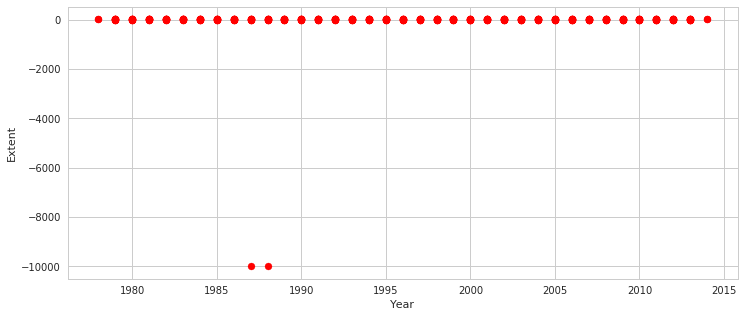

In [61]:
# Visualize the data
x=ice.year
y=ice.extent
plt.scatter(x, y, color='red')
plt.xlabel('Year')
plt.ylabel('Extent')

We detect some outlier or missing data.

In [62]:
print('Different values in data_type field: {}'.format(np.unique(ice.data_type.values)))   # there is a -9999 value!

Different values in data_type field: ['-9999' 'Goddard' 'NRTSI-G']


In [63]:
# Let's see what type of data we have more than Goddard and NRTSI-G 
print(ice[(ice.data_type!='Goddard') & (ice.data_type!='NRTSI-G')])

     year  mo data_type region  extent    area
9    1988   1     -9999      N -9999.0 -9999.0
397  1987  12     -9999      N -9999.0 -9999.0


In [64]:
# We can easily clean the data now:
ice2 = ice[ice.data_type != '-9999']
print('shape: {}'.format(ice2.shape))
# And repeat the plot
x=ice2.year
y=ice2.extent
plt.scatter(x, y, color='red')
plt.xlabel('Month')
plt.ylabel('Extent')

shape: (422, 6)


/Users/laura/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


2) To compute the tendency for a given interval of time (month), we need to normalize the data.

The ``lmplot()`` function from the Seaborn module is intended for exploring linear relationships of different forms in multidimensional datesets. Input data must be in a Pandas ``DataFrame``. To plot them, we provide the predictor and response variable names along with the dataset

/Users/laura/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


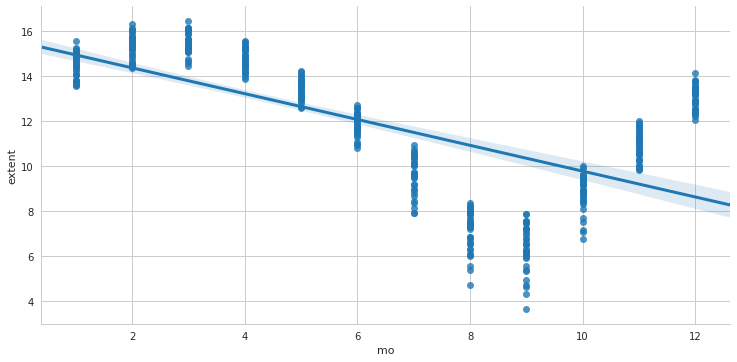

In [65]:
sns.lmplot("mo", "extent", ice2, size=5.2,aspect=2);

In [66]:
# Compute the mean for each month.
grouped = ice2.groupby('mo')
month_means = grouped.extent.mean()
month_variances = grouped.extent.var()
print('Means: {}'.format(month_means))
print('Variances: {}'.format(month_variances))

Means: mo
1     14.479429
2     15.298889
3     15.491714
4     14.766000
5     13.396000
6     11.860000
7      9.601143
8      7.122286
9      6.404857
10     8.809143
11    10.964722
12    13.059429
Name: extent, dtype: float64
Variances: mo
1     0.304906
2     0.295804
3     0.237209
4     0.215378
5     0.189901
6     0.247918
7     0.679175
8     0.824577
9     1.143902
10    0.630361
11    0.412511
12    0.284870
Name: extent, dtype: float64


We can compute the mean for that interval of time (using the period 1981 through 2010 for the mean extend) and we subtract it from the mean extend for that interval. This value must be converted to percent difference by dividing it by the 1981-2010 average and then multiplying by 100.

In [67]:
# Data normalization
for i in range(12):
    ice2.extent[ice2.mo==i+1] = 100*(ice2.extent[ice2.mo==i+1] - month_means[i+1])/month_means.mean()
    
sns.lmplot("mo", "extent", ice2,size=5.2,aspect=2);

/Users/laura/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/laura/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/laura/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-co

In [68]:
print('mean: {}'.format(ice2.extent.mean()))
print('var: {}'.format(ice2.extent.var()))

mean: -6.503486532875325e-15
var: 31.983239774968794


3) This values can be plotted for the entire time series or for particular months. 

Let us consider the entiere year.

/Users/laura/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


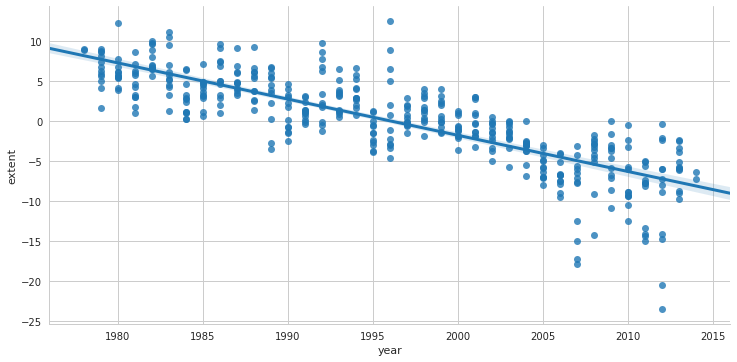

In [69]:
sns.lmplot("year", "extent", ice2,size=5.2,aspect=2);

/Users/laura/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


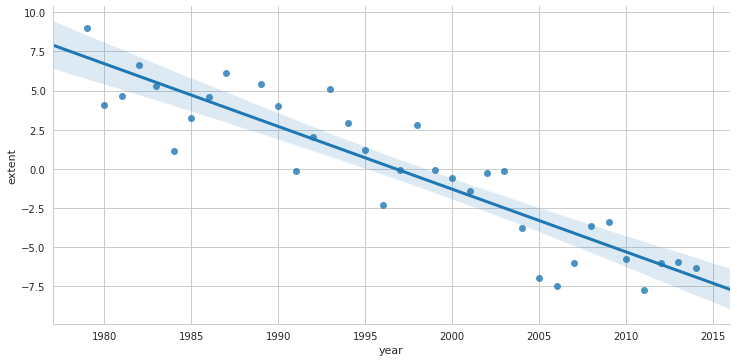

In [70]:
#For January
jan = ice2[ice2.mo==1];
sns.lmplot("year", "extent", jan,size=5.2,aspect=2);

In [71]:
# For August
aug = ice2[ice2.mo==8]
sns.lmplot("year", "extent", aug,size=5.2,aspect=2);

/Users/laura/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [72]:
# Calculates a Pearson correlation coefficient and the p-value for testing non-correlation.
import scipy.stats
scipy.stats.pearsonr(ice2.year.values, ice2.extent.values)

(-0.81835007098971768, 4.4492318168694647e-103)

4) We can also compute the trend as a simple linear regression (OLS) and quantitatively evaluate it.

For that we use using Scikit-learn, library that provides a variety of both supervised and unsupervised machine learning techniques.
Scikit-learn provides an object-oriented interface centered around the concept of an Estimator. 
The <code>Estimator.fit</code> method sets the state of the estimator based on the training data. Usually, the data is comprised of a two-dimensional numpy array $X$ of shape <code>(n_samples, n_predictors)</code> that holds the so-called feature matrix and a one-dimensional numpy array $\textbf{y}$ that holds the responses. Some estimators allow the user to control the fitting behavior. 
For example, the <code>sklearn.linear_model.LinearRegression</code> estimator allows the user to specify whether or not to fit an intercept term. This is done by setting the corresponding constructor arguments of the estimator object.
During the fitting process, the state of the estimator is stored in instance attributes that have a trailing underscore ('_'). For example, the coefficients of a LinearRegression estimator are stored in the attribute coef_.

In [73]:
from sklearn.linear_model import LinearRegression

est = LinearRegression()

x = ice2[['year']]
y = ice2[['extent']]

est.fit(x, y)

print(est.coef_),
print(est.intercept_)

[[-0.45275459]]
[ 903.71640207]


The measures of MSE, EV and $R^2$ can provide a quantitative answer to the question we are facing: Is there a negative trend in the evolution of sea ice extent over recent years?

MSE: 10.539131639803518
EV: 0.5067870382100239
R^2: 0.5067870382100239


/Users/laura/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


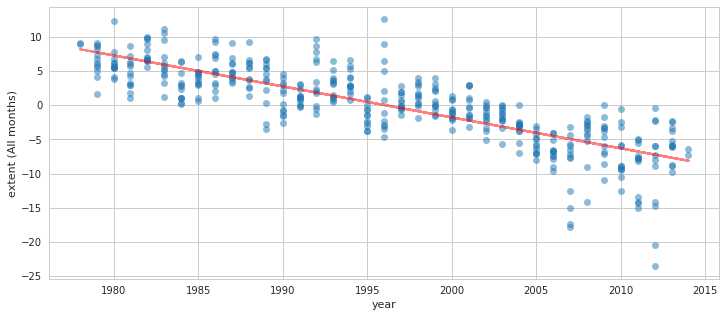

In [74]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Analysis for all months together.
x = ice2[['year']]
y = ice2[['extent']]
model = LinearRegression()
model.fit(x, y)
y_hat = model.predict(x)
plt.plot(x, y,'o', alpha=0.5)
plt.plot(x, y_hat, 'r', alpha=0.5)
plt.xlabel('year')
plt.ylabel('extent (All months)')
print("MSE: {}".format(metrics.mean_squared_error(y_hat, y)))
print("EV: {}".format(metrics.explained_variance_score(y_hat, y)))
print("R^2: {}".format(metrics.r2_score(model.predict(x), y)))

We can conclude that the data show a long-term negative trend in recent years.

MSE: 3.839516075286746
R^2: 0.781063604139622


/Users/laura/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


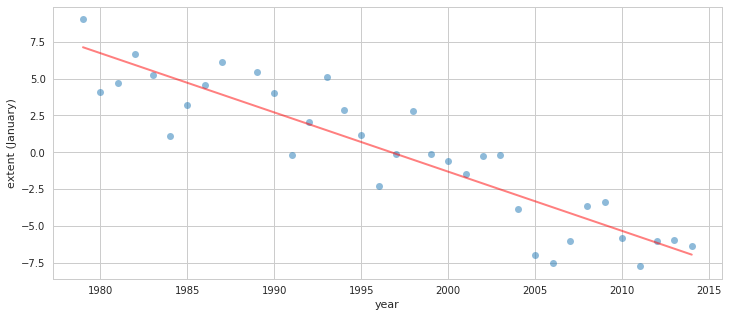

In [75]:
# Analysis for a particular month: january
x = jan[['year']]
y = jan[['extent']]

model = LinearRegression()
model.fit(x, y)

y_hat = model.predict(x)

plt.figure()
plt.plot(x, y,'o', alpha=0.5)
plt.plot(x, y_hat, 'r', alpha=0.5)
plt.xlabel('year')
plt.ylabel('extent (January)')

print("MSE: {}".format(metrics.mean_squared_error(y_hat, y)))
print("R^2: {}".format(metrics.r2_score(model.predict(x), y)))

5) We can also estimate the extent value for 2025.

In [76]:
X=np.array([2025])
X = np.expand_dims(X, axis=1)
X.shape

(1, 1)

In [77]:
X=np.array([2025])
X = np.expand_dims(X, axis=1)
X.shape
y_hat = model.predict(X)
j=1 # January
# Original value (before normalization)
y_hat=(y_hat*month_means.mean()/100)+month_means[j]
print("Prediction for January 2025 (in millions of square km): {}".format(y_hat))

Prediction for January 2025 (in millions of square km): [[ 13.14449923]]


<div class="alert alert-success" style = "border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">
**EXERCISE 2: Advertising dataset**<p>


In the following example we will use the advertising dataset which consists of the sales of products and their advertising budget in three different media TV, radio, newspaper.<p>

**Is there a linear relationship between the sales of products and the advertising budget in TV, radio or newspapers?**<p>


Dataset from the book: "An Introduction to Statistical Learning with Applications in R”. Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani.<p>


</div>

In [78]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
df_adv = pd.read_csv('http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv', index_col=0)
X = df_adv[['TV', 'radio']]
y = df_adv['sales']
df_adv.head()

TV  radio  newspaper  sales
1  230.1   37.8       69.2   22.1
2   44.5   39.3       45.1   10.4
3   17.2   45.9       69.3    9.3
4  151.5   41.3       58.5   18.5
5  180.8   10.8       58.4   12.9

We can show this for two predictor variables in a three dimensional plot. 

In [79]:
from mpl_toolkits.mplot3d import Axes3D

## fit a OLS model with intercept on TV and Radio
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()

## Create the 3d plot 
xx1, xx2 = np.meshgrid(np.linspace(X.TV.min(), X.TV.max(), 100), 
                       np.linspace(X.radio.min(), X.radio.max(), 100))
# plot the hyperplane by evaluating the parameters on the grid
Z = est.params[0] + est.params[1] * xx1 + est.params[2] * xx2

# create matplotlib 3d axes
fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig, azim=-115, elev=15) # azim, stores the azimuth angle in the x,y plane; elev, stores the elevation angle in the z plane 

# plot hyperplane
surf = ax.plot_surface(xx1, xx2, Z, cmap=plt.cm.RdBu_r, alpha=0.6, linewidth=0) # cmap, a colormap for the surface patches.
# linewidth=0, allows not drawing lines on the surface

# plot data points - points over the HP are white, points below are black
resid = y - est.predict(X)
ax.scatter(X[resid >= 0].TV, X[resid >= 0].radio, y[resid >= 0], color='black', alpha=1.0, facecolor='white')
ax.scatter(X[resid < 0].TV, X[resid < 0].radio, y[resid < 0], color='black', alpha=1.0)

# set axis labels
ax.set_xlabel('TV')
ax.set_ylabel('radio')
ax.set_zlabel('sales')
plt.figure()

/Users/laura/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Explore relations using scatter plot matrix and extract some conclusions

In [80]:
# your code here
a = pd.scatter_matrix(df_adv, figsize=(10.0,10.0))  

/Users/laura/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  
/Users/laura/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


**Conclusions**:
It seems that there is a linear relationship between the advertising budget in TV and the sales of products.
However, there is not a relationship between the advertising budget in newspapers and the sales of products.



<div class="alert alert-success" style = "border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">
**EXERCISE 3** Diabetes <p>

The diabetes dataset (from scikit-learn) consists of 10 physiological variables (age, sex, weight, blood pressure) measure on 442 patients, and an indication of disease progression after one year.<p>

We will explore the performance of Linear Regression model and LASSO model for prediction.<p>

Fill the gaps of the exercise.

</div>

Load the data

In [81]:
from sklearn import datasets
diabetes = datasets.load_diabetes()
X,y = diabetes.data, diabetes.target
print(X.shape, y.shape)

(442, 10) (442,)


In [82]:
from sklearn.utils import shuffle
X,y = shuffle(X,y,random_state=1)

Divide in training and testing sets and evaluate the prediction (sklearn) with a simple and a multiple regression model.

For the simple model, first choose one of the dimensions of the data.

Let's use column 2 to perform a regression:

In [83]:
X2 = X[:,2:3]
X2.shape

(442, 1)

In [84]:
plt.scatter(X2, y, alpha=0.5)

/Users/laura/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [85]:
# We will split the data into training set and test set:
train_size = 250
X_train = X2[:train_size]
X_test = X2[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]
print(X_train.shape, X_test.shape)

(250, 1) (192, 1)


Visualize the data using scatter plot (plt.scatter)

/Users/laura/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


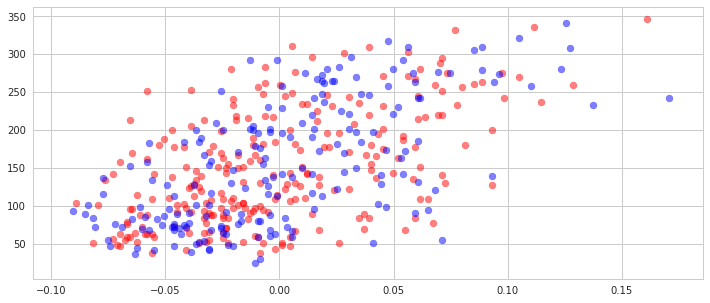

In [86]:
# Data visualization:
plt.scatter(X_train, y_train, color='red', alpha=0.5)
plt.scatter(X_test, y_test, color='blue', alpha=0.5)

Train and evaluate the score of the test set.

In [87]:
from sklearn import linear_model
regr1 = LinearRegression()
regr1.fit(X_train, y_train) 
print(regr1.coef_, regr1.intercept_)
print('Score: {}'.format(regr1.score(X_test, y_test)))

[ 865.04619508] 151.179169728
Score: 0.3859274760681176


Calculate the Mean Squared Error on the train and test set:

In [88]:
print('Training MSE: {}'.format(np.mean((regr1.predict(X_train) - y_train)**2)))
print('Test MSE: {}'.format(np.mean((regr1.predict(X_test) - y_test)**2)))

Training MSE: 3800.1408249628944
Test MSE: 4047.242996701057


Visualize the predicted line together with a scatter plot of the training set.

In [89]:
plt.scatter(X_train, y_train, color='black')
plt.plot(X_train, regr1.predict(X_train), color='red')
plt.xlabel('Data')
plt.ylabel('Target')


/Users/laura/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Visualize the predicted line together with a scatter plot of the test set.

/Users/laura/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


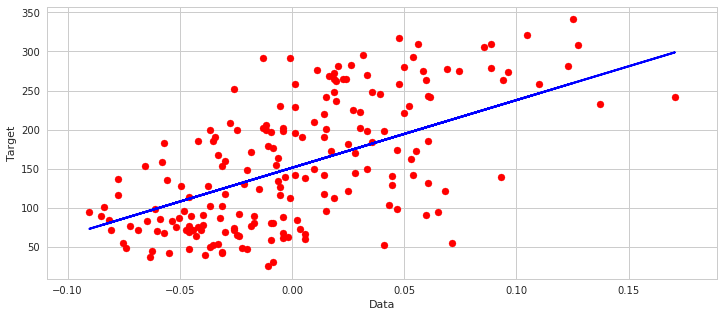

In [90]:
plt.scatter(X_test, y_test, color='red')
plt.plot(X_test, regr1.predict(X_test), color='blue')
plt.xlabel('Data')
plt.ylabel('Target')

For multiple regression model divide in training and testing sets and evaluate the prediction (sklearn) without and with LASSO regularization.

In [91]:
from sklearn import datasets
from sklearn.utils import shuffle

diabetes = datasets.load_diabetes()
X,y = diabetes.data, diabetes.target
print("Data set: {}".format(X.shape, y.shape))
X,y = shuffle(X,y,random_state=1)

train_size = 250
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]
print("Training set: {}".format(X_train.shape, y_train.shape))
print("Test set: {}".format(X_test.shape, y_test.shape))

Data set: (442, 10)
Training set: (250, 10)
Test set: (192, 10)


In [92]:
from sklearn import linear_model
regr2 = LinearRegression()
regr2.fit(X_train, y_train) 
print('Coefficients: {}'.format(regr2.coef_, regr2.intercept_))
print('Score: {}'.format( regr2.score(X_test, y_test))) # Best possible score is 1.0, lower values are worse.

Coefficients: [  59.30928679 -262.53114295  486.58933003  315.00056427 -622.17511657
  306.71816167  -63.19624232  106.14908594  678.27146356   28.92018351]
Score: 0.5445644264522568


In [93]:
print('Training MSE: {}'.format(np.mean((regr2.predict(X_train) - y_train)**2)))
print('Test MSE: {}'.format(np.mean((regr2.predict(X_test) - y_test)**2)))

Training MSE: 2804.059932275545
Test MSE: 3001.695017532003


Is the score improving using all 10 variables?

Score increases from 0.3859 to 0.5445 using all 10 variables. But it is another test!

Now, with a sparse model:

In [94]:
# Create a Lasso regressor
regr3 = linear_model.Lasso(alpha=.3)
regr3.fit(X_train, y_train) 
print('Coefficients: {}'.format(regr3.coef_)) # very sparse coefficients
print('Score: {}'.format(regr3.score(X_test, y_test))) # Best possible score is 1.0, lower values are worse
# The coeficients now are sparse
# But, the score is almost the same

Coefficients: [   0.          -10.76176706  450.90551082  202.44375768   -0.           -0.
 -159.09510339    0.          364.42592524    0.        ]
Score: 0.5066938452799925


In [95]:
print('Training MSE: {}'.format(np.mean((regr3.predict(X_train) - y_train)**2)))
print('Test MSE: {}'.format(np.mean((regr3.predict(X_test) - y_test)**2)))

Training MSE: 3069.889461393766
Test MSE: 3251.293295352763


Is the score different? 

The previous result was:
Coefficients: [  59.30928679 -262.53114295  486.58933003  315.00056427 -622.17511657
  306.71816167  -63.19624232  106.14908594  678.27146356   28.92018351] 150.817222886
Score: 0.544564426452
Training MSE:  2804.05993228
Test MSE:  3001.69501753

Almost the same results with less "activated" coefficients (the result has 5 zero coefficients).

<div class="alert alert-success" style = "border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">
**EXERCISE 4: Winning or Losing Football Team** <p>

We want to predict victory or defeat in a football match when we are given the number of goals a team scores.
To do this we consider the set of results of the football matches from the Spanish league and we build a classification model with it. <p>

We follow the steps:
<ul>
    <li> Read this file in a pandas DataFrame: http://www.football-data.co.uk/mmz4281/1213/SP1.csv
    <li> Select these columns in a new DataFrame: 'HomeTeam','AwayTeam', 'FTHG', 'FTAG', 'FTR'. (FTHG: Home team goals, FTAG: Away team goals, FTR: H=Home Win, D=Draw, A=Away Win)
    <li> Visualize a scatter plot of FTHG versus FTAG.
    <li> Built a $X$ 1-d predictor with all scores and a $y$ binary variable indicating win or loss.
    <li> Compute and visualize a logistic regression. 
    <li> Which is the cut value?

</div>

In [96]:
import pylab as pl

# Season 2012/2013
file = 'files/ch06/SP1.csv' # file = 'http://www.football-data.co.uk/mmz4281/1213/SP1.csv'
footballData = pd.read_csv(file)
s = footballData[['HomeTeam','AwayTeam', 'FTHG', 'FTAG', 'FTR']]

In [97]:
s.head() # (H=Home Win, D=Draw, A=Away Win)

HomeTeam  AwayTeam  FTHG  FTAG FTR
0       Celta    Malaga     0     1   A
1    Mallorca   Espanol     2     1   H
2     Sevilla    Getafe     2     1   H
3  Ath Bilbao     Betis     3     5   A
4   Barcelona  Sociedad     5     1   H

Can we predict if we have a win or loss if we are given a score?

To answer this question, we can follow the steps:
* Visualization with scatter plot the number of goals with transparecy (alpha channel).
* Create two extra columns containing 'W' the number of goals of the winner and 'L' the number of goals of the losser
* Create the data and target: concatenate the number of goals of the winner and the number of goals of the losser
* Plot the 2-dimensional data
* Fitting of a Logistic Regression and prediction using the model
* Estimate which is the cut off value.

In [98]:
# Visualization with scatter the number of goals
pl.scatter(s.FTHG, s.FTAG, s=100, alpha=0.03) 
# s, size of the points, alpha, blending value, between 0 (transparent) and 1 (opaque).
plt.xlabel('Home team goals (FTHG)')
plt.ylabel('Away team goals (FTAG)')


/Users/laura/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [99]:
# Create two extra columns containing 'W' the number of goals of the winner and 'L' the number of goals of the losser
def my_f1(row):
    return max(row['FTHG'], row['FTAG'])

def my_f2(row):
    return min(row['FTHG'], row['FTAG'])

# Add 2 new columns to the panda:
s['W'] = s.apply(my_f1, axis=1)
s['L'] = s.apply(my_f2, axis=1)


/Users/laura/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/laura/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [100]:
s.info()
s.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 7 columns):
HomeTeam    380 non-null object
AwayTeam    380 non-null object
FTHG        380 non-null int64
FTAG        380 non-null int64
FTR         380 non-null object
W           380 non-null int64
L           380 non-null int64
dtypes: int64(4), object(3)
memory usage: 20.9+ KB


HomeTeam  AwayTeam  FTHG  FTAG FTR  W  L
0       Celta    Malaga     0     1   A  1  0
1    Mallorca   Espanol     2     1   H  2  1
2     Sevilla    Getafe     2     1   H  2  1
3  Ath Bilbao     Betis     3     5   A  5  3
4   Barcelona  Sociedad     5     1   H  5  1

In [101]:
# Create the data and target
import numpy as np
x1 = s['W'].values 
y1 = np.ones(len(x1), dtype=np.int)
x2 = s['L'].values 
y2 = np.zeros(len(x2), dtype=np.int)

x = np.concatenate([x1,x2])
x = x[:, np.newaxis]
y = np.concatenate([y1,y2])


In [102]:
# Plot the data 
plt.scatter(x,y, s=100, alpha=0.03)
plt.xlabel('Number of goals')
plt.ylabel('Win (1) or loss (0)')


/Users/laura/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [103]:
# Fitting of a Logistic Regression and prediction using the model:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(x,y)

pl.clf()

X_test = np.linspace(-5, 10, 300)
def model(x):
    return 1 / (1 + np.exp(-x))
loss = model(X_test * logreg.coef_ + logreg.intercept_).ravel()

X_test2 = X_test[:,np.newaxis]
losspred = logreg.predict(X_test2)

pl.scatter(x.ravel(), y, color='black', s=100, zorder=20,  alpha=0.03)
pl.plot(X_test, loss, color='blue', linewidth=3)
pl.plot(X_test, losspred, color='red', linewidth=3)
pl.xlabel('Number of goals')
pl.ylabel('Victory (1) or Defeat (0)')


/Users/laura/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


With this information we can estimate that the cut off value is 1. This means that a team has to score at least one goal to win.


<div class="alert" style = "border-radius:10px;border-width:3px;border-color:darkblue;font-family:Verdana,sans-serif;font-size:16px;">
**EXTRA ANALYSIS FOR THE BOSTON DATA** 

In order to compare the fitting of the lineal and polynomial regression models we can also use the sklearn library.

Next we add a quantitative evaluation of the two models.

In [104]:
boston = datasets.load_boston()
X_boston,y_boston = boston.data, boston.target

In [105]:
# Evaluation of the linear model
X_boston,y_boston = boston.data, boston.target

regr_boston = LinearRegression()
regr_boston.fit(X_boston, y_boston) 

#print('Coeff and intercept: {} {}'.format(regr_boston.coef_, regr_boston.intercept_))
print('Multiple Linear regression Score: {}'.format(regr_boston.score(X_boston, y_boston)))
print('Multiple Linear regression MSE: {}'.format(np.mean((regr_boston.predict(X_boston) - y_boston)**2)))

Multiple Linear regression Score: 0.7406077428649427
Multiple Linear regression MSE: 21.8977792176875


In [106]:
# Evaluation of the polynomial model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

regr_pol = Pipeline([('poly', PolynomialFeatures(degree=2)),('linear', LinearRegression(fit_intercept=False))])
regr_pol.fit(X_boston, y_boston) 

#print('Coeff and intercept: {} {}'.format(regr_pol.named_steps['linear'].coef_, regr_pol.named_steps['linear'].intercept_))
print('Multiple Polynomial regression Score: {}'.format(regr_pol.score(X_boston, y_boston)))
print('Multiple Polynomial regression MSE: {}'.format(np.mean((regr_pol.predict(X_boston) - y_boston)**2)))

Multiple Polynomial regression Score: 0.9291464466583601
Multiple Polynomial regression MSE: 5.981425525188429


For the simple regresssion, we first need to extract one of the features and then use the same methods:

In [107]:
# Quantitative evaluation of the SIMPLE lineal and polynomial regression:
bostonDF = pd.DataFrame(boston.data)
bostonDF.head()

0     1     2    3      4      5     6       7    8      9     10  \
0  0.00632  18.0  2.31  0.0  0.538  6.575  65.2  4.0900  1.0  296.0  15.3   
1  0.02731   0.0  7.07  0.0  0.469  6.421  78.9  4.9671  2.0  242.0  17.8   
2  0.02729   0.0  7.07  0.0  0.469  7.185  61.1  4.9671  2.0  242.0  17.8   
3  0.03237   0.0  2.18  0.0  0.458  6.998  45.8  6.0622  3.0  222.0  18.7   
4  0.06905   0.0  2.18  0.0  0.458  7.147  54.2  6.0622  3.0  222.0  18.7   

       11    12  
0  396.90  4.98  
1  396.90  9.14  
2  392.83  4.03  
3  394.63  2.94  
4  396.90  5.33

In [108]:
bostonDF.columns=boston.feature_names 
bostonDF.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  
0     15.3  396.90   4.98  
1     17.8  396.90   9.14  
2     17.8  392.83   4.03  
3     18.7  394.63   2.94  
4     18.7  396.90   5.33

In [109]:
x=bostonDF['LSTAT']
y=boston.target
x = np.expand_dims(x, axis=1)
y = np.expand_dims(y, axis=1)

In [110]:
regr_boston = LinearRegression()
regr_boston.fit(x, y) 

print('Simple linear regression Score: {}'.format(regr_boston.score(x, y)))
print('Simple linear regression MSE: {}'.format(np.mean((regr_boston.predict(x) - y)**2)))

regr_pol = Pipeline([('poly', PolynomialFeatures(degree=2)),('linear', LinearRegression(fit_intercept=False))])
regr_pol.fit(x, y) 

print('Simple Polynomial regression (order 2) Score: {}'.format(regr_pol.score(x, y)))
print('Simple Polynomial regression (order 2) MSE: {}'.format(np.mean((regr_pol.predict(x) - y)**2)))

regr_pol = Pipeline([('poly', PolynomialFeatures(degree=3)),('linear', LinearRegression(fit_intercept=False))])
regr_pol.fit(x, y) 

print('Simple Polynomial regression (order 3) Score: {}'.format(regr_pol.score(x, y)))
print('Simple Polynomial regression (order 3) MSE: {}'.format(np.mean((regr_pol.predict(x) - y)**2)))

Simple linear regression Score: 0.5441462975864799
Simple linear regression MSE: 38.48296722989414
Simple Polynomial regression (order 2) Score: 0.6407168971636611
Simple Polynomial regression (order 2) MSE: 30.330520075853716
Simple Polynomial regression (order 3) Score: 0.6578476405895719
Simple Polynomial regression (order 3) MSE: 28.88435031921317
